<img src="figures/ampel.png" width="200">

### AMPEL and the Vera C. Rubin Observatory

The Vera Rubin Observatory, and the LSST survey, will provide a legacy collection of real-time data. Considering the potential long term impact of any transient programs, the AMPEL analysis platform was developed to 
host complex science program with provenance requirements matching those of the observatory. In essence, this means the creation of _scientific analysis schema_ which detail all scientific/algorithmic choices being made. This schema can be distributed with publications, and consistently applied to simulated, archived and real-time datasets.

##### This notebook : Creating an AMPEL channel

This notebook presents a sample strategy for designing a channel (in this case for an extra-galactic science case). It is closely aligned with `Tutorial 1` and `Tutorial 2` from this repository.

#### Sample science case

Each AMPEl _channel_ is designed with a science goal (or "experiment/hypothesis/test") in mind. A much discussed current topic is the origin of the extragalactic neutrino flux observed e.g. by IceCube, with one of the potential sources being supernovae interacting with circumstellar material (SNIIn). We here wish to investigate whether a particular subtype of these, SN2009ip-like SNe with recent previous outbursts, are regularly found within the uncertainty region of neutrino alerts. 

The steps for this science program would be: Identify transients with optical lightcurves compatible with SN2009ip AND which coincide with neutrino alerts. For such targets, obtain follow-up spectroscopy to confirm classification (i.e. an external reaction). 

Below: Lightcurve of SN2009ip compared with other SNIIn (from Margutti et al 2013)

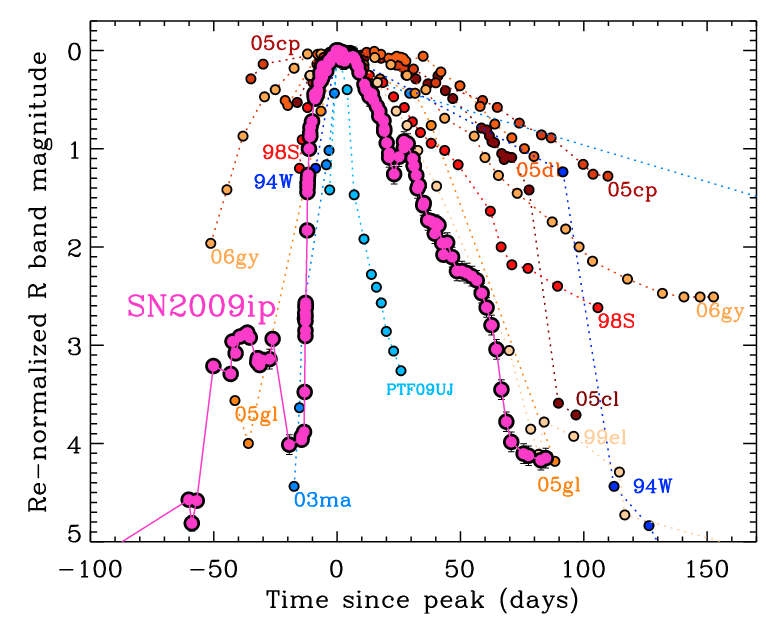 

#### AMPEL tiers

Alert processing in AMPEL is carried out in four separate tiers:

|   |  |
| -------- | ----- | 
![alt-text-1](figures/ampel-tiers2_titleless.png "title-1") | ![alt-text-2](figures/ampel-tiers_titleless.png "title-2")


#### This notebook

This notebook reads alerts from a provided fixed collection of alerts, filters these and performs a lightcurve template match. In particular, it compares whether the lightcurve is better fit by SN2009ip than a normal SNIa (the main assumed false-positive).

This is done fully sequential, in the notebook, without relying on any external database or units.

In [ ]:
%load_ext ampel_quick_import
%qi AmpelLogger SimpleDecentFilterCopy DevAlertProcessor DevAmpelContext AbsLightCurveT2Unit LightCurve ZTFAlert ProcessModel
from ampel.type import T2UnitResult
import numpy as np
from astropy.table import Table
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", category=DeprecationWarning, module="sncosmo")
    import sncosmo    

### Traversing and filtering a local alert collection

In [ ]:
# Path to an alert archive.
# In principle, the full ZTF alert history can be accessed through https://ztf.uw.edu/alerts/public/
# This repository contains an initial small set of 200 alerts taken from Sep 17 2020.
ALERT_ARCHIVE = '../sample_data/ztfpub_200917_pruned.tar.gz'

In [ ]:
# Every log message is (later) stored in the DB
logger = AmpelLogger.get_logger()

In [ ]:
# As the first step, a basic filter will be applied to the alert stream
# In particular, the search we will do is only meaningful for transients with a certain number
# of detections.
t0filter = SimpleDecentFilterCopy(
        min_rb=0.3,
        min_ndet=7,
        min_tspan=10,
        max_tspan = 200,
        min_gal_lat=15,
        logger=logger
    )

In [ ]:
# This sets up a local alert processor, which can traverse a collection of ZTF alerts.
# AMPEL contains other alert processors, most notable those which accepts a live stream (e.g. Kafka)
ap = DevAlertProcessor( t0filter )

In [ ]:
# Lets now process the first iter_max alerts
iter_max = 1000
n_processed = ap.process_tar( ALERT_ARCHIVE, iter_max=iter_max )

In [ ]:
print('Processed %s alerts out of which %s were accepted'%(n_processed,len(ap.get_accepted_alerts())))

### Comparing the lightcurves

In [ ]:
# First, we define the calculation we wish to apply to the alert content (a photometric LightCurve)
class T2FindSN2009ip(AbsLightCurveT2Unit):
    """
    This module tests whether a state LightCurve is well matched by SN2009ip.
    To be this, it has to:
    - Provide good fit to the data
    - Provide a better fit than a SNIa lightcurve
    Evaluations done using SNCosmo.
    Warning: MW or host galaxy reddening not accounted for!
    
    The run method, applied to a LightCurve, will return a dict (T2UnitResult).
    In this 
       'model_match':True
    for selected objects. 
    (For this sample case we also include the fitted model).
    
    """

    snIa_model_name: str = 'salt2'
    sn09ip_model_name: str = 'v19-2009ip-corr' 

        
    def post_init(self)-> None:
        """
        Retrieve models.
        """
        self.sn09ipmodel = sncosmo.Model(source=self.sn09ip_model_name)
        self.saltmodel = sncosmo.Model(source=self.snIa_model_name)
        
    def run(self, light_curve: LightCurve) -> T2UnitResult:
        """
        

        Parameters
        -----------
        light_curve: "ampel.view.LightCurve" instance.
        See the LightCurve docstring for more info.

        Returns
        -------
        dict
        """

        self.logger.info('Fitting %s'%(light_curve.stock_id) )

        # Create SNCosmo input table
        phot = np.asarray( light_curve.get_ntuples(('jd','magpsf','sigmapsf','fid')) )
        phot_tab = Table(phot,names=('jd','magpsf','sigmapsf','fid'))
        phot_tab['band'] = 'ztfband'
        for fid, fname in zip( [1,2,3], ['ztfg','ztfr','ztfi']):
            phot_tab['band'][phot_tab['fid']==fid] = fname
        phot_tab['flux'] = 10 ** (-(phot_tab['magpsf'] - 25) / 2.5)
        phot_tab['fluxerr'] = np.abs(phot_tab['flux'] * (-phot_tab['sigmapsf'] / 2.5 * np.log(10)))
        phot_tab['zp'] = 25
        phot_tab['zpsys'] = 'ab'
        
        # Fit SNIa
        try:
            result, fitted_model = sncosmo.fit_lc(
                phot_tab, self.saltmodel,
                ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
                bounds={'z':(0., 0.2)})  
            chidof_snia = result.chisq / result.ndof
        except RuntimeError:
            # We interpret a poor fit a a weird lightcurve, and exit
            self.logger.info("Salt fit fails",extra={"stock_id":light_curve.stock_id})
            return {'chidof_snia':np.inf,'chidof_09ip':0, 'model_match': False, 'info': 'saltfit fails'}
        
        # Fit Vincenzi et al. 2019 model of SN2009ip
        # SN2009ip-like objects as neutrino sources?
        try:
            result, fitted_model = sncosmo.fit_lc(
                phot_tab, self.sn09ipmodel, vparam_names=['z', 't0', 'amplitude'], bounds={'z':(0,0.2)}  )  
            chidof_09ip = result.chisq / result.ndof
        except RuntimeError:
            # We interpret a poor fit a a weird lightcurve, and exit
            self.logger.info("Model fit fails",extra={"stock_id":light_curve.stock_id})
            return {'chidof_snia':chidof_snia,'chidof_09ip':np.inf, 'model_match': False, 'info': 'saltfit failes'}
        
        # Gather information to propagate / log
        fit_info = {'chidof_snia':chidof_snia,'chidof_09ip':chidof_09ip}

        # Crude decision made
        # Want a reasonable fit
        if chidof_09ip>3:
            fit_info['model_match'] = False
            fit_info['info'] = 'Poor lc match'
        # Do not want the salt model to be "much" better
        elif chidof_snia < ( chidof_09ip * 0.5 ):
            fit_info['model_match'] = False
            fit_info['info'] = 'Better SNIa fit'

        else:
            fit_info['model_match'] = True
            fit_info['info'] = 'Good match'
            fit_info['fit_table'] = phot_tab
            fit_info['fit_model'] = fitted_model
            fit_info['fit_errors'] = result.errors
        
        self.logger.info("",extra={'SN90ip_match':fit_info['model_match']} )

        
        return fit_info

In [ ]:
# Initiate our lightcurve tester
analysis_unit = T2FindSN2009ip(logger=logger)

In [ ]:
# Traverse the accepted alerts and record output
analysis_output = {}
for k, al in enumerate(ap.get_accepted_alerts()):
    lc = ZTFAlert.to_lightcurve(pal=al)
    analysis_output[al.id] = analysis_unit.run(lc)

In [ ]:
for sn, t2dict in analysis_output.items():
    if not t2dict['model_match']: 
        continue
    print(sn)
    _ = sncosmo.plot_lc(t2dict['fit_table'], model=t2dict['fit_model'], errors=t2dict['fit_errors'])

#### Importing the unit from repository

The following lines repeat the same steps as above, but through using a version of `T2FindSN2009ip` saved to the repository. The motivation for this is that this module can be tagged, referenced and loaded by other Ampel users (for example a live instance).

In [ ]:
from ampel.contrib.sample.t2.T2SNcosmoComp import T2SNcosmoComp

In [ ]:
T2SNcosmoComp??

In [ ]:
# The unit is loaded with comparison models selected
t2 = T2SNcosmoComp(target_model_name='v19-2009ip-corr', base_model_name='salt2', chi2dof_cut=2, 
                   chicomp_scaling=0.5, logger=logger)

In [ ]:
# Traverse the accepted alerts and record output (as above)
t2_output = {}
for k, al in enumerate(ap.get_accepted_alerts()):
    lc = ZTFAlert.to_lightcurve(pal=al)
    t2_output[al.id] = t2.run(lc)

In [ ]:
t2_output['ZTF20abyfpze']

###  Putting a channel into production

We now have the initial seed for a scientific program. There are obvious _scientific_ improvements that can be made: take reddening into account, more sophisticated model treatment or why not add some sklearn ML test? Most of these can be constructed as straightforward extensions of `T2SNcosmoComp`. 

Ignoring that, we are now only one step away from having the analysis uploaded to a live AMPEL instance: the creation of a fully specified analysis schema. This will be merged with the AMPEL configuration file and split into processes at the different tiers. The sample configuration here is taken from [https://github.com/AmpelProject/Ampel-contrib-sample/blob/master/conf/ampel-contrib-sample/channel/SAMPLE_CHANNEL.yml](https://github.com/AmpelProject/Ampel-contrib-sample/blob/master/conf/ampel-contrib-sample/channel/SAMPLE_CHANNEL.yml).

```
channel: SAMPLE_CHANNEL
contact: maintainer_contact@doe.com
active: false
auto_complete: live
template: ztf_uw_public
t0_filter:
  unit: DecentFilter
  config:
    min_rb: 0.3
    min_ndet: 7
    min_tspan: 10
    max_tspan: 200
    min_gal_lat: 15
t2_compute:
  - unit: T2SNcosmoComp
    config: 
      target_model_name: v19-2009ip-corr 
      base_model_name: salt2 
      chi2dof_cut: 2.
  - unit: T2MultiMessMatch
    config:
      temporal_pull_scaling: 1
      spatial_pull_scaling: 3.
      energy_pull_scaling: 0.001
      match_where: 'latest'
t3_supervise:
    template: ztf_periodic_summary
    schedule: every(30).seconds
    filter: 
      t2:
        all_of: 
        - unit: T2SNcosmoComp
          match: 
            target_match: true
        - unit: T2MultiMessMatch
          match: 
            best_match:
              $lt: 1
    run:
      - unit: T3HelloWorld
        config: 
          t2info_from: 
            - T2SNcosmoComp
            - T2MultiMessMatch
```

**This schema contains all the information necessary for rerunning the analysis**: from how the initial stream is chosen, how it is parsed and analyzed. The `T2MultiMessMatch` unit was introdued in _Tutorial 2_ (or AmpelMultiMessenger). The T3 tier details what reactions should be taken for transients that exceed some detection thresholds based on the T2 output, and is further described in _Tutorial 4_. It is compact enough for inclusion in publication, and general enough to convert into use by other data processing frameworks.